## **Análise de dados: evasão escolar no ensino superior**

---

---

Classificação de dados de evasão no ensino superior. O objetivo é correlacionar dados de evasão escolar no ensino superior com dados socieconômicos dos curos de licenciatura do IFNMG-Salinas.

##**Conjunto de dados**

Esta base de dados é composta por 22 atributos, nos quais:
* 21 características 
* 1  rótulo

**Importação de dados**


---


In [ ]:
#[1]Bibliotecas
from google.colab import files
import pandas as pd
import io

In [ ]:
#[2]importando conjuntos e dados já limpo(removidas variáveis descessárias e com dados faltantes)

uploaded = files.upload() # uploaded é um dicionário, sendo a chave o nome do arquivo
data_evasao = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))

Saving data_licen.csv to data_licen.csv


In [ ]:
#visualizando dados
data_evasao.head(2)

,atv_remunerada,renda_mensal,num_mem_familia,renda_mensal_familia,sit_pai_trabalho,sit_mae_trabalho,ens_fundamental,ens_medio,tempo_concluiu_ens_medio,cor,hab_ler_jornal_revista,livros_lidos_ano,atv_ocup_tempo,meio_informado,faixa_etaria,procedencia,rep_ens_fundamental,rep_ens_medio,esc_pai,esc_mae,deficiencia,Evadiu
0,Nao,Nao tenho nenhuma renda mensal.,De 1 a 3 pessoas,"De 1 até 1,5 salário mínimo.",Outra situação,Outra situação,Escola pública municipal,Escola pública federal,Há mais de 5 anos,"Pardo(a), Mulato(a)",Diariamente,Mais de 05 livros,Nenhuma dessas atividades,Internet,De 30 a 39 anos,Zona rural,1 vez,Nenhuma vez,Ensino fundamental completo,Ensino fundamental incompleto,Não apresento nenhum tipo de deficiência,Sim
1,Nao,Nao tenho nenhuma renda mensal.,De 4 a 6 pessoas,"De 1 até 1,5 salário mínimo.",Trabalha regularmente,Trabalha regularmente,Escola pública estadual,Escola pública estadual,Entre 3 e 4 anos (incompletos),"Pardo(a), Mulato(a)",Semanalmente,Mais de 05 livros,Televisão,Jornal falado (TV),De 20 a 24 anos,Zona urbana,Nenhuma vez,Nenhuma vez,Ensino fundamental incompleto,Ensino fundamental incompleto,Não apresento nenhum tipo de deficiência,Sim


##**Pré-Processamento**

**Transformação/Conversão de dados**


---



```OneHotEncoder```


In [ ]:
#Bibliotecas
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()

enc.fit(data_evasao)  #Ajuste do OneHotEncoder para pré-processamento

new_data = enc.transform(data_evasao).toarray() #Transformação dos dados categóricos em características binárias

print('Conjunto de dados transformado com sucesso!\n')
print(f'Número de colunas do conjunto de dados: {new_data.shape[1]}')
print(f'Número de linhas do conjunto de dados: {new_data.shape[0]}')

Conjunto de dados transformado com sucesso!

Número de colunas do conjunto de dados: 119
Número de linhas do conjunto de dados: 256


**Separação das variáveis de entrada e saída**


---


In [ ]:
#Separação das entradas e saídas do modelo
X = new_data[:, :(new_data.shape[1]-2)]   
y = new_data[:, new_data.shape[1]-2:] #Duas últimas colunas do array

print(f'Entradas: {X.shape[1]}')
print(f'Saídas: {y.shape[1]}')

Entradas: 117
Saídas: 2


In [ ]:
#Bibliotecas
import numpy as np

# Indentificando os rótulos das classes
data = np.array(data_evasao)
labels = []
for line in range(data.shape[0]):
  if(labels.count(data[line, data.shape[1]-1])==0):
    labels.append(data[line, data.shape[1]-1])

**Divisão dos conjuntos de treinamento e teste**

---

In [ ]:
# [1] Bibliotecas
from sklearn.model_selection import train_test_split

#Gerando os conjuntos de treinamento e teste/validação
train_x, test_x, train_y, test_y = train_test_split(X,y, test_size=0.25) #30% dos dados para teste

print('Conjuntos de treinamento e teste separados!\n')
print(f'São {train_x.shape[0]} dados para o treinamento e {test_x.shape[0]} para teste.')

Conjuntos de treinamento e teste separados!

São 192 dados para o treinamento e 64 para teste.


## **Seleção de Topologias por Validação K-Fold**

In [ ]:
#Bibliotecas
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore") # ignorando warnings da MLP

#Gerando os conjuntos de treinamento e teste
train_x, test_x, train_y, test_y = train_test_split(X,y, test_size=0.25)

# ponto de partida da camada oculta
neurons = (train_x.shape[1]+train_y.shape[1])//2
rand_seeds =  [0, 32, 64, 96, 127]
actv_funcs =  ['logistic', 'relu']

hp = [] 
val_scores = []
train_scores = []
mean_scores =[]

#Preparação do procedimento de validação cruzada
cv = KFold(n_splits=10, random_state=1, shuffle=True)

print('AC.VAL.  | TOPOLOGIA ')

# loop de otimização
while(neurons>=1):
  for actv_func in actv_funcs:
    for rand_seed in rand_seeds:
      # define modelo com base no hiperparametro
      model = MLPClassifier(neurons,activation=actv_func, max_iter=5000, alpha=0.01,
                      solver='sgd', learning_rate_init=0.1, momentum=0.9, learning_rate='adaptive', random_state=rand_seed, verbose=0 )
      
      # treina modelo e realiza previsão no conj de validação
      vs = cross_val_score(model, train_x, train_y, cv=cv) #validação kfld
      
      
      val_acc = np.mean(vs) #média dos valores kfold
      val_scores.append(val_acc)
    
      hp.append([neurons, actv_func, rand_seed])

      print('{:.2}      {}'.format(val_acc,[neurons, actv_func, rand_seed]))
  neurons = neurons//2


print('\n\n------------------ RESULTADO -------------------------------')

best_i = np.argmax(val_scores)                                                                                                                                                                                                                                                                                                                          
print('\nMelhor modelo: ', best_i, hp[best_i])
print('Acurácia do Conjunto de Validação: {:.4}%'.format(val_scores[best_i]*100))




AC.VAL.  | TOPOLOGIA 
0.55      [59, 'logistic', 0]
0.57      [59, 'logistic', 32]
0.58      [59, 'logistic', 64]
0.58      [59, 'logistic', 96]
0.56      [59, 'logistic', 127]
0.58      [59, 'relu', 0]
0.59      [59, 'relu', 32]
0.56      [59, 'relu', 64]
0.59      [59, 'relu', 96]
0.57      [59, 'relu', 127]
0.58      [29, 'logistic', 0]
0.55      [29, 'logistic', 32]
0.56      [29, 'logistic', 64]
0.55      [29, 'logistic', 96]
0.58      [29, 'logistic', 127]
0.58      [29, 'relu', 0]
0.55      [29, 'relu', 32]
0.57      [29, 'relu', 64]
0.56      [29, 'relu', 96]
0.55      [29, 'relu', 127]
0.58      [14, 'logistic', 0]
0.57      [14, 'logistic', 32]
0.58      [14, 'logistic', 64]
0.54      [14, 'logistic', 96]
0.55      [14, 'logistic', 127]
0.56      [14, 'relu', 0]
0.59      [14, 'relu', 32]
0.57      [14, 'relu', 64]
0.57      [14, 'relu', 96]
0.55      [14, 'relu', 127]
0.61      [7, 'logistic', 0]
0.56      [7, 'logistic', 32]
0.57      [7, 'logistic', 64]
0.57      [7, 'logi

## **Treinamento**

Perda Logarítmica: 0.2346


Text(0, 0.5, 'perda')

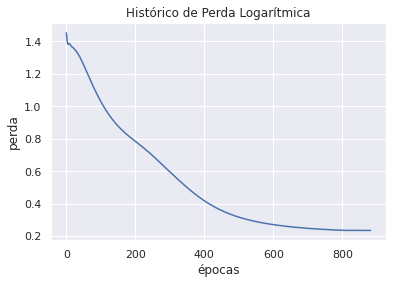

In [ ]:
# treina com hiperparametro mais adequado
model = MLPClassifier(hp[best_i][0],activation=hp[best_i][1], max_iter=5000, alpha=0.1,
                      solver='sgd', learning_rate_init=0.1, momentum=0.9, learning_rate='adaptive', random_state=hp[best_i][2], verbose=0 )
      
model = model.fit(train_x, train_y)

train_y_pred = model.predict(train_x)

#Calcula a perda logaritmica
l_loss = model.best_loss_

print('Perda Logarítmica: {:.4}'.format(l_loss))

# exibindo a curva de perda logarítmica
plt.plot(model.loss_curve_)
plt.title('Histórico de Perda Logarítmica')
plt.xlabel('épocas')
plt.ylabel('perda')

## **Análise dos conjuntos de treinamento e teste**

--------------- ANÁLISE DO CONJUNTO DE TREINAMENTO -------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      1.00      1.00       100

   micro avg       1.00      1.00      1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192
 samples avg       1.00      1.00      1.00       192

Acurácia no Conjunto de Treinamento: 100.0%



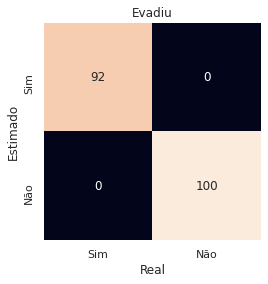

In [ ]:
print('--------------- ANÁLISE DO CONJUNTO DE TREINAMENTO -------------------\n')

# Análise do conjunto de treinamento
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


#print(' Relatório de Classificação')
print(classification_report(train_y, train_y_pred)) # mostra relatório

acc_train = accuracy_score(train_y, train_y_pred)
print('Acurácia no Conjunto de Treinamento: {:.4}%\n'.format(acc_train*100))

mat = confusion_matrix(train_y.argmax(axis=-1), train_y_pred.argmax(axis=-1))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Evadiu')
plt.xlabel('Real')
plt.ylabel('Estimado');

----------------- ANÁLISE DO CONJUNTO DE TESTE -----------------------

              precision    recall  f1-score   support

           0       0.61      0.69      0.65        29
           1       0.71      0.63      0.67        35

   micro avg       0.66      0.66      0.66        64
   macro avg       0.66      0.66      0.66        64
weighted avg       0.66      0.66      0.66        64
 samples avg       0.66      0.66      0.66        64

Acurácia no Conjunto de Teste: 65.62%



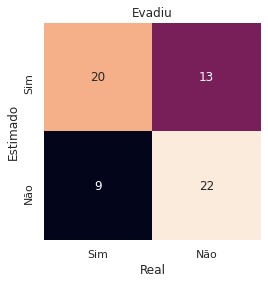

In [ ]:
print('----------------- ANÁLISE DO CONJUNTO DE TESTE -----------------------\n')
#Análise do conjunto de teste
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

test_y_pred = model.predict(test_x)

print(classification_report(test_y, test_y_pred))

acc_test = accuracy_score(test_y, test_y_pred)
print('Acurácia no Conjunto de Teste: {:.4}%\n'.format(acc_test*100))

# matriz de confusão
mat = confusion_matrix(test_y.argmax(axis=1), test_y_pred.argmax(axis=1))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Evadiu')
plt.xlabel('Real')
plt.ylabel('Estimado');

